In [1]:
!pip install pandas numpy seaborn matplotlib plotly scipy

In [2]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.2.2
anyio                        4.9.0
appnope                      0.1.4
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.5
attrs                        25.3.0
babel                        2.17.0
beautifulsoup4               4.13.4
bleach                       6.2.0
certifi                      2025.4.26
cffi                         1.17.1
charset-normalizer           3.4.2
comm                         0.2.2
contourpy                    1.3.2
cycler                       0.12.1
debugpy                      1.8.14
decorator                    5.2.1
defusedxml                   0.7.1
exceptiongroup               1.2.2
executing                    2.2.0
fastjsonschema               2.21.1
flatbuffers                  25

In [3]:
import os
import tensorflow as tf
# Only show errors from TF, hide INFO logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

In [4]:
#import libraries
import pandas as pd
import numpy as np

#plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg
import random

#deep learning libraries
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input

from collections import Counter
from collections import defaultdict


TensorFlow GPU Memory Growth

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Enable memory growth so TF only uses what it needs
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print("Could not set memory growth:", e)

GPU memory growth enabled


Loading the Data

Set Paths

In [7]:
# Set the paths to fruit dataset folders for both train and test
train_path = "/Users/krishnaajaishi/Desktop/Tech3300 Machine Learning/data 2/train"
test_path = "/Users/krishnaajaishi/Desktop/Tech3300 Machine Learning/data 2/test"

# Image size and batch size for the model
img_size = (100, 100) # all the images will be resized to 100 w * 100 h pixels
batch_size = 32     # 32 images are fed into the model at a time during training


In [8]:
# Function to count the number of image files in a train and test directory 

def count_images_in_directory(directory):
    total_images = 0  # Initialize total image counter

    # Loop through each class subfolder in the directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)  # Full path to the class folder

        # Check if it's actually a directory (ignores non-folder items)
        if os.path.isdir(class_path):
            # List only image files with valid extensions
            image_files = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            # Add the number of images in this class to the total
            total_images += len(image_files)

    return total_images  # Return the total count

# Use the function to count images in training and test sets
n_train = count_images_in_directory(train_path)  # Total training images
n_test = count_images_in_directory(test_path)    # Total testing images

# Display the counts
print(f"Number of training images: {n_train}")
print(f"Number of testing images: {n_test}")


Number of training images: 6024
Number of testing images: 663


Loading Training and Validation Data

In [9]:
# ImageDataGenerator for training data with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0, 1]
    rotation_range=20,             # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,         # Randomly shift the width of images by 20%
    height_shift_range=0.2,        # Randomly shift the height of images by 20%
    shear_range=0.2,               # Apply shear transformations
    zoom_range=0.2,                # Zoom into the images by 20%
    horizontal_flip=True,          # Randomly flip images horizontally
    fill_mode='nearest',           # Fill in missing pixels after transformation
    validation_split=0.2           # Reserve 20% of the data for validation
)

# ImageDataGenerator for validation data without augmentation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,                # Only normalize pixel values, no augmentation
    validation_split=0.2           # Same split for consistency
)

# Load training data (80% of the data) with augmentation
train_data = train_datagen.flow_from_directory(
    train_path,                    # Path to the directory with class subfolders
    target_size=img_size,          # Resize all images to specified size (e.g., 100x100)
    batch_size=batch_size,         # Load images in batches (e.g., 32)
    class_mode='categorical',      # One-hot encode class labels
    subset='training',             # Use only the training portion
    shuffle=True,                  # Shuffle the data each epoch
    seed=42                        # Set seed for reproducibility
)

# Load validation data (20% of the data) without augmentation
val_data = val_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',           # Use only the validation portion
    shuffle=True,
    seed=42
)


Found 4822 images belonging to 14 classes.
Found 1202 images belonging to 14 classes.


In [10]:
for images, labels in train_data:
    print(images.shape, labels.shape)
    break

(32, 100, 100, 3) (32, 14)


Inspect the Dataset

In [11]:
# Check data types of the train and validation data

print(train_data.dtype)
print(val_data.dtype)


# checking class labels

# Dictionary of class names

print("Class Indices:")
for class_name, index in train_data.class_indices.items():
    print(f"{class_name}: {index}")

print("Total number of classes:", len(train_data.class_indices))



float32
float32
Class Indices:
Apple Granny Smith: 0
Apricot: 1
Avocado: 2
Banana: 3
Blueberry: 4
Cactus fruit: 5
Cherry: 6
Corn: 7
Kiwi: 8
Mango: 9
Orange: 10
Pineapple: 11
Strawberry: 12
Watermelon: 13
Total number of classes: 14


In [12]:
# counting the images per class from the training dataset (both train and validation)

# Count images in the training set
train_counts = Counter(train_data.classes)

# Count images in the validation set
val_counts = Counter(val_data.classes)

# Print class-wise counts for training data
print("No. of Samples of Each Class of Training Data:")
for class_index, count in train_counts.items():

    # Create a dictionary to map numeric indices back to class names and get the class name for a given index

    class_name = list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(class_index)]

    # find the index in the list of values [0, 1, 2]  →  index of 2 is 2 & list(train_data.class_indices.keys())[2]  → 'orange'
    
    print(f"{class_name}: {count}")

print(f"\nTotal number of training images: {sum(train_counts.values())}")

# Print class-wise counts for validation data
print("\nNo. of Samples of Each Class of Validation Data:")
for class_index, count in val_counts.items():

    # Create a dictionary to map numeric indices back to class names and get the class name for a given index

    class_name = list(val_data.class_indices.keys())[list(val_data.class_indices.values()).index(class_index)]
    print(f"{class_name}: {count}")


print(f"\nTotal number of Validation images: {sum(val_counts.values())}")



No. of Samples of Each Class of Training Data:
Apple Granny Smith: 361
Apricot: 361
Avocado: 305
Banana: 353
Blueberry: 329
Cactus fruit: 353
Cherry: 361
Corn: 321
Kiwi: 337
Mango: 345
Orange: 337
Pineapple: 353
Strawberry: 361
Watermelon: 345

Total number of training images: 4822

No. of Samples of Each Class of Validation Data:
Apple Granny Smith: 90
Apricot: 90
Avocado: 76
Banana: 88
Blueberry: 82
Cactus fruit: 88
Cherry: 90
Corn: 80
Kiwi: 84
Mango: 86
Orange: 84
Pineapple: 88
Strawberry: 90
Watermelon: 86

Total number of Validation images: 1202


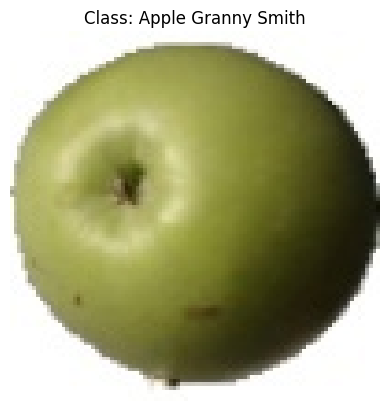

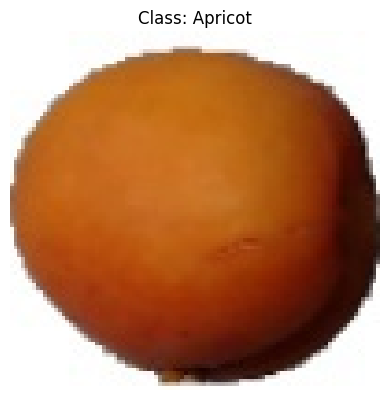

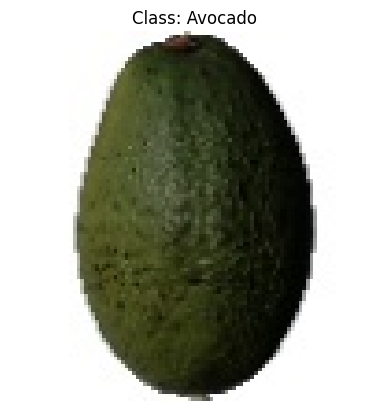

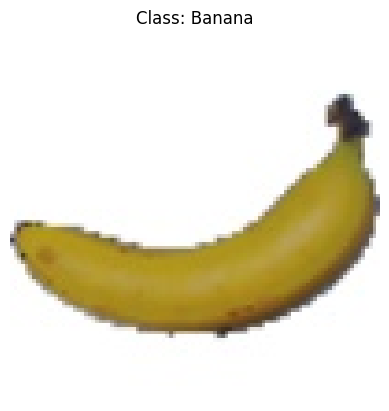

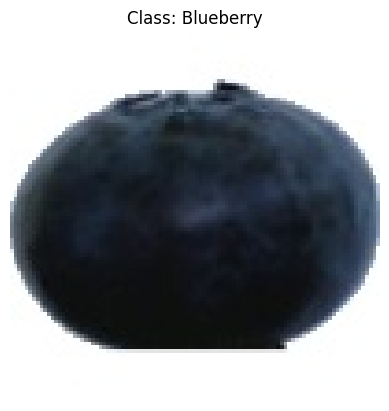

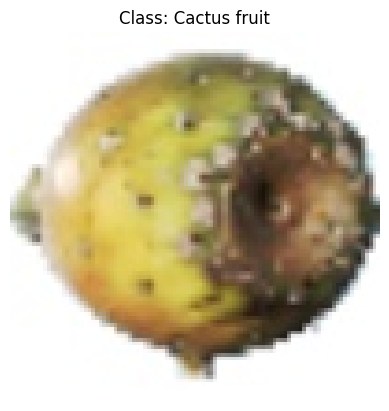

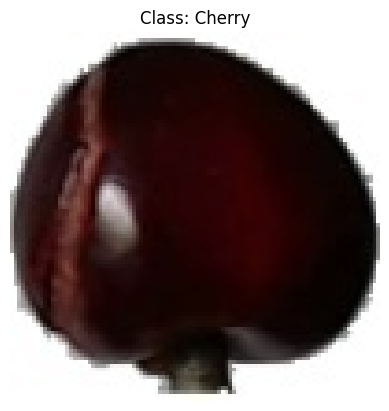

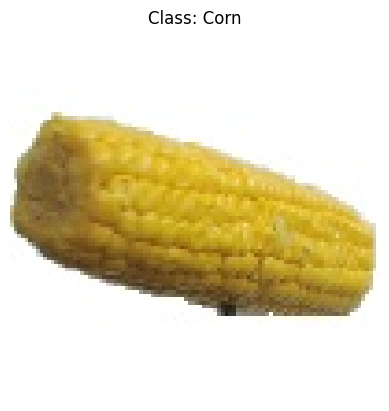

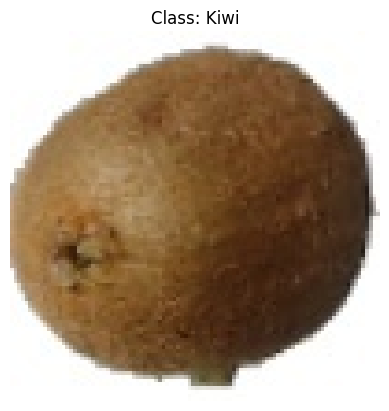

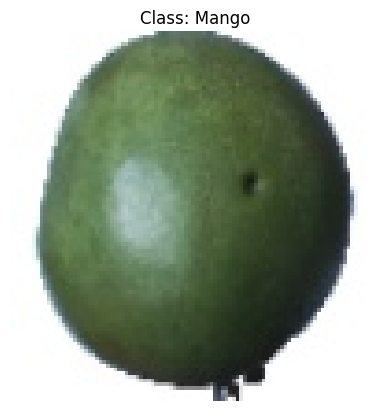

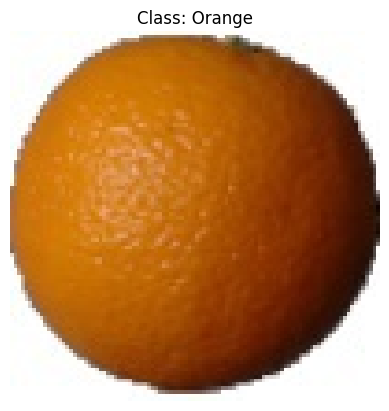

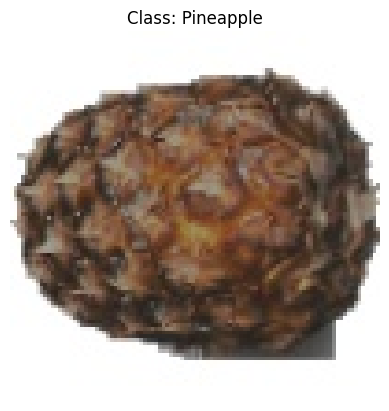

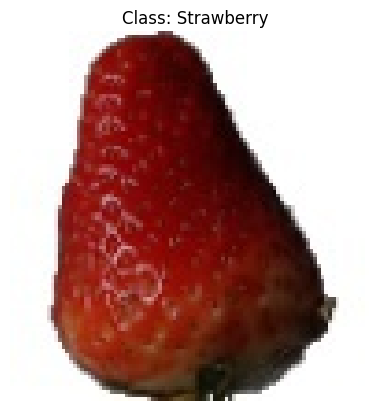

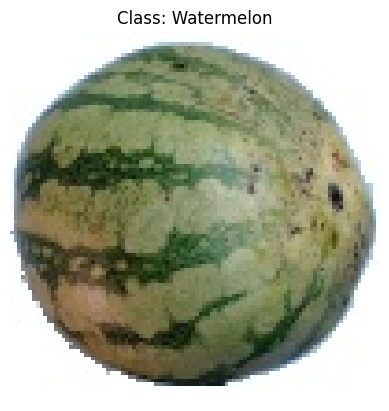

In [13]:
# Visualizing sample images from Train data

# Loop through each fruit class using class names from train_data
for class_name in train_data.class_indices.keys():
    
    # Build the full path to the folder containing images for that class
    class_folder = os.path.join(train_path, class_name)  # e.g., train/apple

    # Get all image file names in the class folder that end with .jpg or .png
    image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png'))]

    # Proceed only if there are any image files in the folder
    if image_files:
        
        # Randomly choose one image from the list
        random_image = random.choice(image_files)
        
        # Get the full path to that selected image file
        image_path = os.path.join(class_folder, random_image)

        # Read the image from the file
        img = mpimg.imread(image_path)
        
        # Show the image using matplotlib
        plt.imshow(img)
        
        # Set the title of the image plot as the class name
        plt.title(f"Class: {class_name}")
        
        # Hide axis ticks and labels for a cleaner display
        plt.axis('off')
        
        # Display the image
        plt.show()




Visualizing the Train and Validation Data

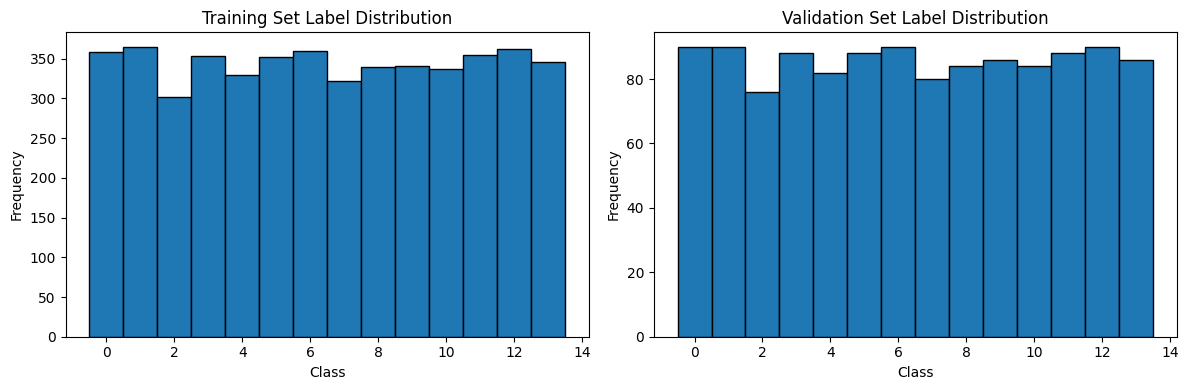

In [14]:
# Let's look at the distribution of labels in the training and validation sets

# Initialize empty lists to store labels
train_labels = []
val_labels = []

# Extract labels from train_data
for _, labels in train_data:
    train_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to integer labels
    if len(train_labels) >= len(train_data.filenames):  # Stop once we've processed all data
        break

# Extract labels from val_data
for _, labels in val_data:
    val_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to integer labels
    if len(val_labels) >= len(val_data.filenames):  # Stop once we've processed all data
        break

# Plot histograms of the label distributions
plt.figure(figsize=(12, 4))

# Training Set Distribution
plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=np.arange(len(train_data.class_indices)+1)-0.5, edgecolor='black')
plt.title("Training Set Label Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

# Validation Set Distribution
plt.subplot(1, 2, 2)
plt.hist(val_labels, bins=np.arange(len(val_data.class_indices)+1)-0.5, edgecolor='black')
plt.title("Validation Set Label Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


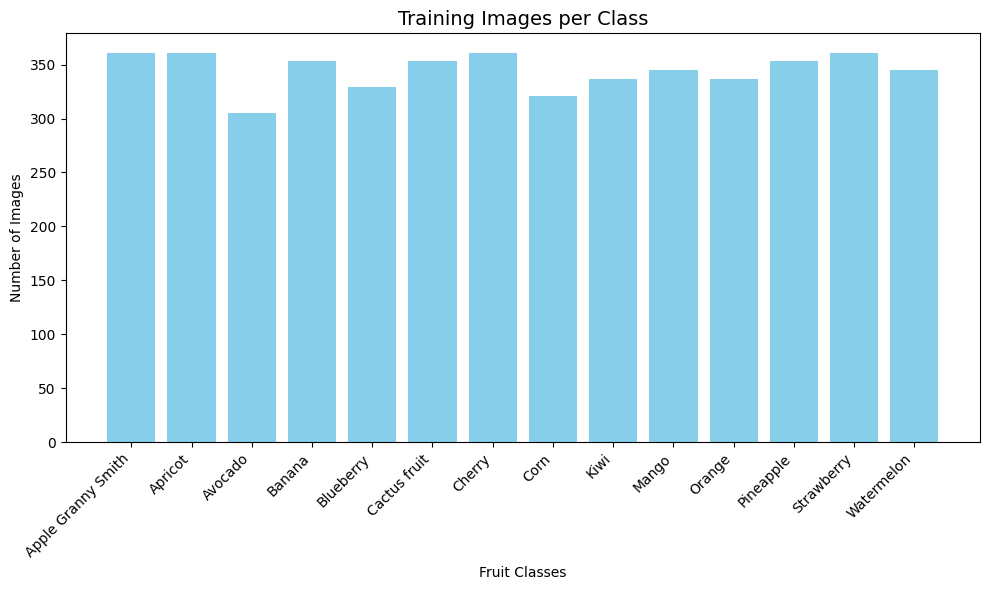

In [15]:
# Visualizing Class Distribution of Training Dataset

# Dictionary to store image counts per class from training data
train_class_counts = defaultdict(int)

# Reverse mapping: index to class name
index_to_class = {v: k for k, v in train_data.class_indices.items()}

# Loop over all image labels (class indices) in training data
for class_index in train_data.classes:
    class_name = index_to_class[class_index]  # Convert index to class name
    train_class_counts[class_name] += 1       # Increment cunt for the class

# ----------------- Visualization ------------------

# Create a bar chart to show training images per class
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='skyblue')  # Bar chart

# Chart title and axis labels
plt.title("Training Images per Class", fontsize=14)
plt.xlabel("Fruit Classes")
plt.ylabel("Number of Images")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to fit all labels
plt.tight_layout()

# Show the plot
plt.show()



Defining LeNet-5 architecture of CNN model for fruit image classifier

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os

In [11]:
# ─── 1. Define the LeNet-5 inspired model builder ──────────────────────────────────────────────────────

def build_lenet5_model(num_filters=32, dropout_rate=0.5):
    """
    Build and return a LeNet-5 inspired CNN model.
    Parameters:
        num_filters: Base number of filters for convolutional layers
        dropout_rate: Dropout rate to prevent overfitting
    """
    model = Sequential([
        tf.keras.layers.Input(shape=(100, 100, 3)),
        Conv2D(num_filters, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(num_filters * 2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(14, activation='softmax')  # 14 fruit classes
    ])
    return model
    

In [12]:
model.summary()

NameError: name 'model' is not defined

In [13]:
# ─── 2. Define the training function ──────────────────────────────────────────────────────

def train_model(train_data, val_data, learning_rate, dropout_rate, num_filters, epochs=15):
    """
    Train the CNN model with the given hyperparameters.
    Parameters:
        train_data, val_data: Training and validation data generators
        learning_rate: Learning rate for SGD
        dropout_rate: Dropout to apply
        num_filters: Number of filters for conv layers
        epochs: Number of training epochs
    Returns:
        model: The trained model
        history: Training history
    """
    tf.keras.backend.clear_session()  # Clear previous models from memory

    # Build and compile the model
    model = build_lenet5_model(num_filters=num_filters, dropout_rate=dropout_rate)
    optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

  # Create directory to save the best model
    results_dir = "LeNet-5/hyperparameter_results"
    os.makedirs(results_dir, exist_ok=True)

    # Callbacks for saving best model
    checkpoint_path = f"{results_dir}/best_lr{learning_rate}_dr{dropout_rate}_nf{num_filters}.keras"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
    ]

    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=2
    )
    return model, history


In [20]:
# ─── 3. Define function to plot training results ─────────────────────────────────────────────

def plot_training_results(history, lr, dr, nf):
    """
    Plot training and validation accuracy and loss over epochs.
    """
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Acc')
    plt.title(f"Accuracy (lr={lr}, dr={dr}, nf={nf})")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss (lr={lr}, dr={dr}, nf={nf})")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.tight_layout()
    plt.show()

    


Training model: LR=0.001, Dropout=0.3, Filters=32
Epoch 1/10


/Users/krishnaajaishi/tf_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.54311, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.3_nf32.keras
151/151 - 7s - 46ms/step - accuracy: 0.2095 - loss: 2.3360 - val_accuracy: 0.4859 - val_loss: 1.5431
Epoch 2/10

Epoch 2: val_loss improved from 1.54311 to 1.03141, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.3_nf32.keras
151/151 - 6s - 38ms/step - accuracy: 0.4204 - loss: 1.6037 - val_accuracy: 0.5740 - val_loss: 1.0314
Epoch 3/10

Epoch 3: val_loss improved from 1.03141 to 0.60744, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.3_nf32.keras
151/151 - 6s - 36ms/step - accuracy: 0.5539 - loss: 1.2013 - val_accuracy: 0.7795 - val_loss: 0.6074
Epoch 4/10

Epoch 4: val_loss improved from 0.60744 to 0.43469, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.3_nf32.keras
151/151 - 6s - 38ms/step - accuracy: 0.6653 - loss: 0.8782 - val_accuracy: 0.8869 - val_loss: 0.4347
Epoch 5/10

Epoch 5: val_loss did not improve f

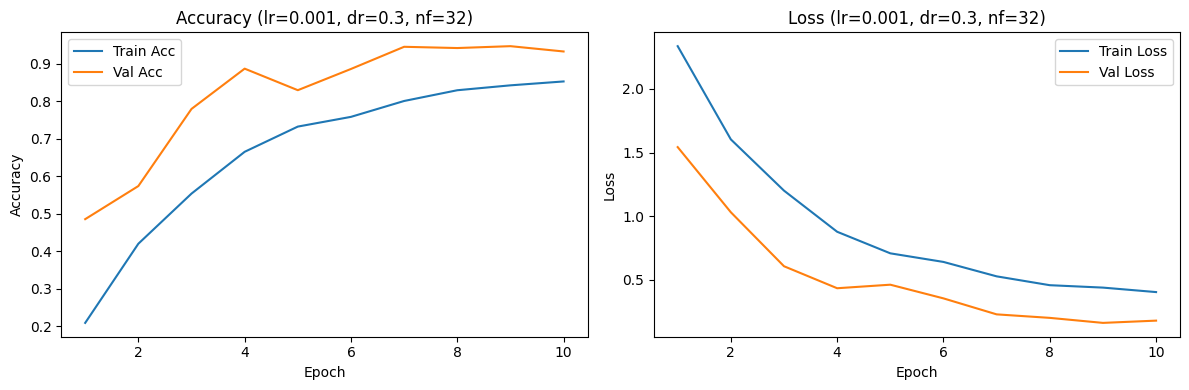


Training model: LR=0.001, Dropout=0.3, Filters=64
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.78667, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.3_nf64.keras
151/151 - 7s - 48ms/step - accuracy: 0.1562 - loss: 2.4622 - val_accuracy: 0.4850 - val_loss: 1.7867
Epoch 2/10

Epoch 2: val_loss improved from 1.78667 to 1.01229, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.3_nf64.keras
151/151 - 7s - 45ms/step - accuracy: 0.3548 - loss: 1.8110 - val_accuracy: 0.6822 - val_loss: 1.0123
Epoch 3/10

Epoch 3: val_loss improved from 1.01229 to 0.79948, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.3_nf64.keras
151/151 - 7s - 46ms/step - accuracy: 0.4724 - loss: 1.4838 - val_accuracy: 0.6913 - val_loss: 0.7995
Epoch 4/10

Epoch 4: val_loss improved from 0.79948 to 0.41423, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.3_nf64.keras
151/151 - 7s - 47ms/step - accuracy: 0.5709 - loss: 1.1923 - val_accuracy: 0.8777 - va

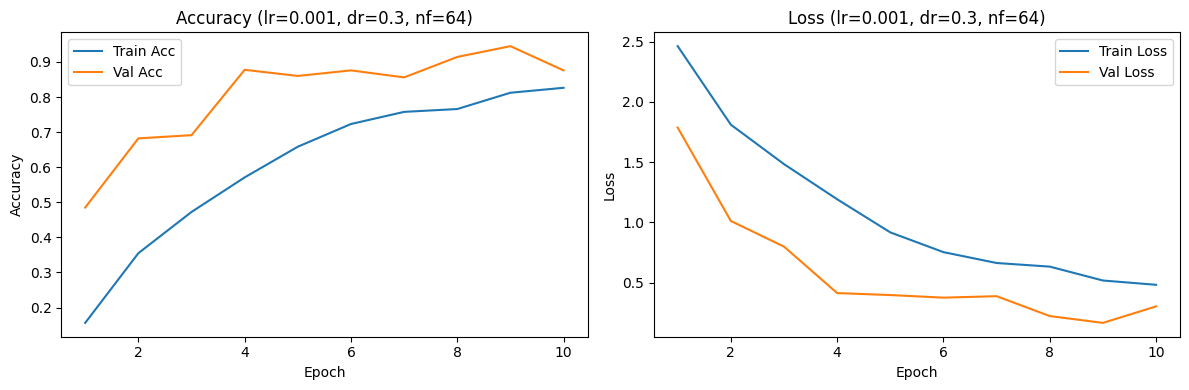


Training model: LR=0.001, Dropout=0.5, Filters=32
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.77840, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.5_nf32.keras
151/151 - 7s - 47ms/step - accuracy: 0.1389 - loss: 2.6435 - val_accuracy: 0.4218 - val_loss: 1.7784
Epoch 2/10

Epoch 2: val_loss improved from 1.77840 to 1.19764, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.5_nf32.keras
151/151 - 11s - 74ms/step - accuracy: 0.2586 - loss: 2.3479 - val_accuracy: 0.5250 - val_loss: 1.1976
Epoch 3/10

Epoch 3: val_loss improved from 1.19764 to 0.95974, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.5_nf32.keras
151/151 - 9s - 58ms/step - accuracy: 0.3488 - loss: 2.0215 - val_accuracy: 0.5948 - val_loss: 0.9597
Epoch 4/10

Epoch 4: val_loss improved from 0.95974 to 0.88887, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.5_nf32.keras
151/151 - 11s - 75ms/step - accuracy: 0.4328 - loss: 1.6619 - val_accuracy: 0.7280 - 

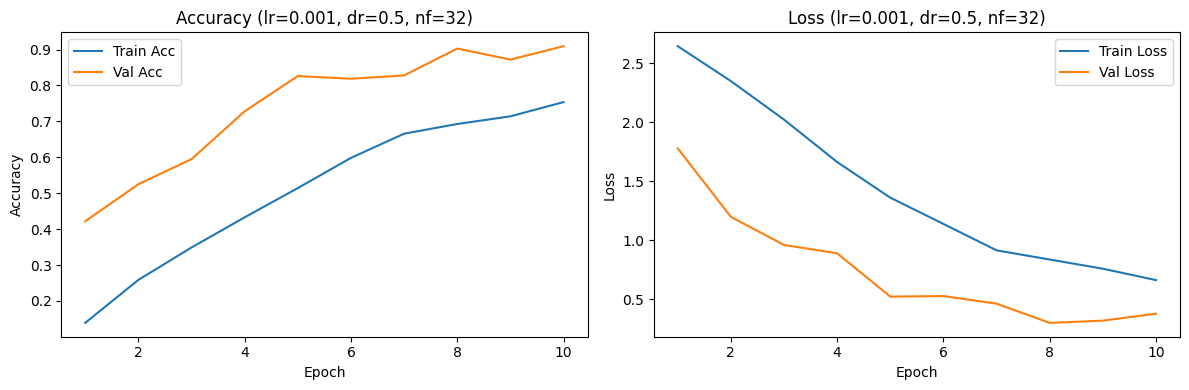


Training model: LR=0.001, Dropout=0.5, Filters=64
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.93245, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.5_nf64.keras
151/151 - 9s - 62ms/step - accuracy: 0.1282 - loss: 2.5556 - val_accuracy: 0.2928 - val_loss: 1.9325
Epoch 2/10

Epoch 2: val_loss improved from 1.93245 to 1.23469, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.5_nf64.keras
151/151 - 7s - 46ms/step - accuracy: 0.2779 - loss: 2.0920 - val_accuracy: 0.5907 - val_loss: 1.2347
Epoch 3/10

Epoch 3: val_loss improved from 1.23469 to 0.81028, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.5_nf64.keras
151/151 - 7s - 45ms/step - accuracy: 0.3712 - loss: 1.8183 - val_accuracy: 0.6456 - val_loss: 0.8103
Epoch 4/10

Epoch 4: val_loss improved from 0.81028 to 0.55152, saving model to LeNet-5/hyperparameter_results/best_lr0.001_dr0.5_nf64.keras
151/151 - 7s - 45ms/step - accuracy: 0.4500 - loss: 1.5930 - val_accuracy: 0.8161 - va

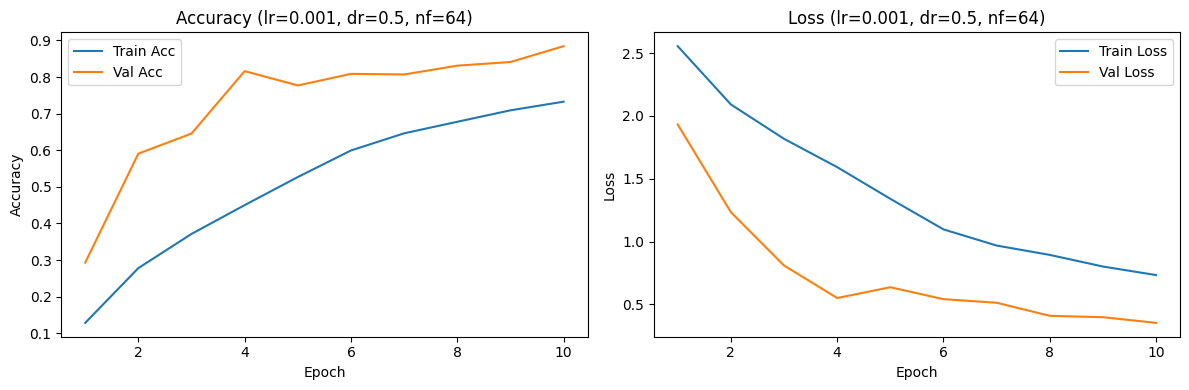


Training model: LR=0.005, Dropout=0.3, Filters=32
Epoch 1/10

Epoch 1: val_loss improved from inf to 0.87004, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.3_nf32.keras
151/151 - 7s - 44ms/step - accuracy: 0.3389 - loss: 1.8757 - val_accuracy: 0.7804 - val_loss: 0.8700
Epoch 2/10

Epoch 2: val_loss improved from 0.87004 to 0.31752, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.3_nf32.keras
151/151 - 6s - 38ms/step - accuracy: 0.7084 - loss: 0.8009 - val_accuracy: 0.8677 - val_loss: 0.3175
Epoch 3/10

Epoch 3: val_loss improved from 0.31752 to 0.19811, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.3_nf32.keras
151/151 - 6s - 37ms/step - accuracy: 0.8073 - loss: 0.5477 - val_accuracy: 0.9260 - val_loss: 0.1981
Epoch 4/10

Epoch 4: val_loss improved from 0.19811 to 0.17359, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.3_nf32.keras
151/151 - 5s - 36ms/step - accuracy: 0.8791 - loss: 0.3416 - val_accuracy: 0.9368 - va

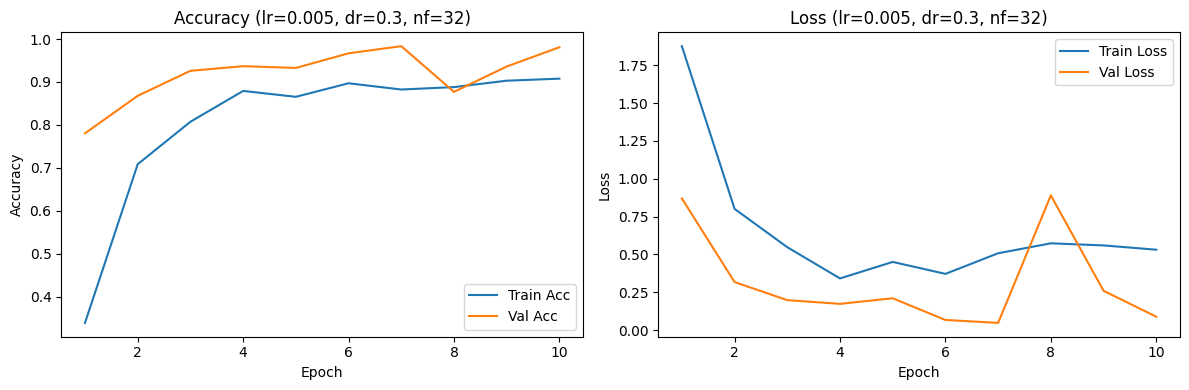


Training model: LR=0.005, Dropout=0.3, Filters=64
Epoch 1/10

Epoch 1: val_loss improved from inf to 0.67744, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.3_nf64.keras
151/151 - 8s - 50ms/step - accuracy: 0.3615 - loss: 1.8442 - val_accuracy: 0.7879 - val_loss: 0.6774
Epoch 2/10

Epoch 2: val_loss improved from 0.67744 to 0.60555, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.3_nf64.keras
151/151 - 7s - 46ms/step - accuracy: 0.7066 - loss: 0.8476 - val_accuracy: 0.7995 - val_loss: 0.6056
Epoch 3/10

Epoch 3: val_loss improved from 0.60555 to 0.28082, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.3_nf64.keras
151/151 - 7s - 46ms/step - accuracy: 0.8082 - loss: 0.5550 - val_accuracy: 0.9002 - val_loss: 0.2808
Epoch 4/10

Epoch 4: val_loss did not improve from 0.28082
151/151 - 7s - 47ms/step - accuracy: 0.8696 - loss: 0.3734 - val_accuracy: 0.8727 - val_loss: 0.7781
Epoch 5/10

Epoch 5: val_loss improved from 0.28082 to 0.04396, sav

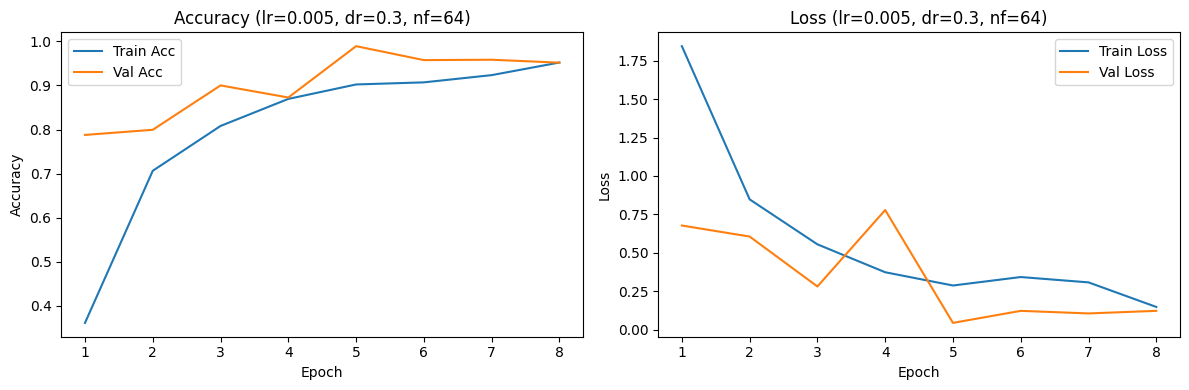


Training model: LR=0.005, Dropout=0.5, Filters=32
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.29165, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.5_nf32.keras
151/151 - 8s - 52ms/step - accuracy: 0.3032 - loss: 2.0097 - val_accuracy: 0.5757 - val_loss: 1.2916
Epoch 2/10

Epoch 2: val_loss improved from 1.29165 to 0.40889, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.5_nf32.keras
151/151 - 7s - 47ms/step - accuracy: 0.5805 - loss: 1.2211 - val_accuracy: 0.8220 - val_loss: 0.4089
Epoch 3/10

Epoch 3: val_loss did not improve from 0.40889
151/151 - 6s - 41ms/step - accuracy: 0.7103 - loss: 0.8711 - val_accuracy: 0.6747 - val_loss: 0.8485
Epoch 4/10

Epoch 4: val_loss did not improve from 0.40889
151/151 - 6s - 41ms/step - accuracy: 0.7254 - loss: 0.9247 - val_accuracy: 0.7496 - val_loss: 0.9120
Epoch 5/10

Epoch 5: val_loss did not improve from 0.40889
151/151 - 6s - 42ms/step - accuracy: 0.7999 - loss: 0.6153 - val_accuracy: 0.7579 - val_lo

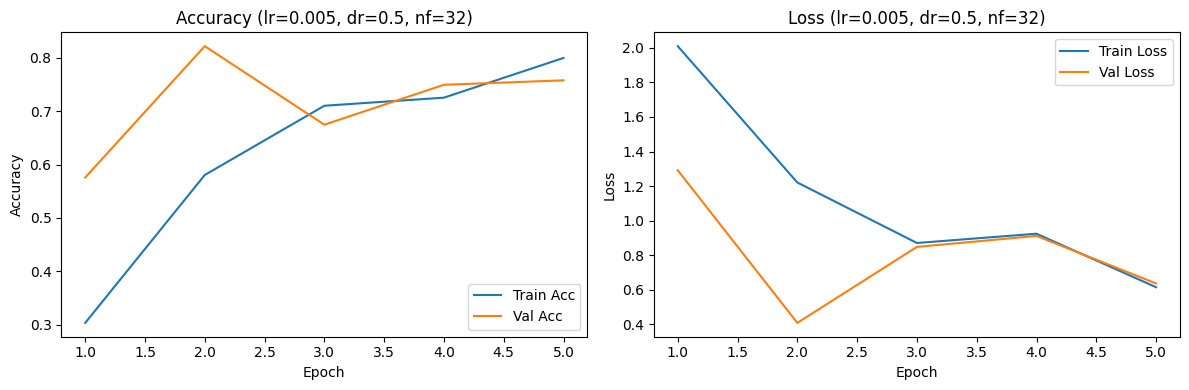


Training model: LR=0.005, Dropout=0.5, Filters=64
Epoch 1/10

Epoch 1: val_loss improved from inf to 0.63807, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.5_nf64.keras
151/151 - 9s - 61ms/step - accuracy: 0.2825 - loss: 2.0930 - val_accuracy: 0.8062 - val_loss: 0.6381
Epoch 2/10

Epoch 2: val_loss did not improve from 0.63807
151/151 - 9s - 58ms/step - accuracy: 0.6205 - loss: 1.0841 - val_accuracy: 0.6681 - val_loss: 1.5285
Epoch 3/10

Epoch 3: val_loss improved from 0.63807 to 0.46735, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.5_nf64.keras
151/151 - 9s - 59ms/step - accuracy: 0.7364 - loss: 0.8988 - val_accuracy: 0.8211 - val_loss: 0.4674
Epoch 4/10

Epoch 4: val_loss improved from 0.46735 to 0.16914, saving model to LeNet-5/hyperparameter_results/best_lr0.005_dr0.5_nf64.keras
151/151 - 9s - 58ms/step - accuracy: 0.7845 - loss: 0.8226 - val_accuracy: 0.9309 - val_loss: 0.1691
Epoch 5/10

Epoch 5: val_loss improved from 0.16914 to 0.09925, sav

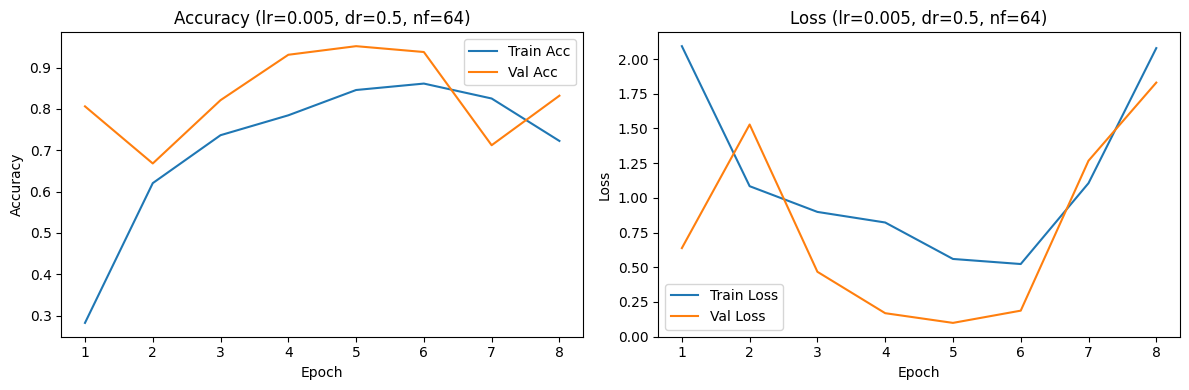


Training model: LR=0.01, Dropout=0.3, Filters=32
Epoch 1/10

Epoch 1: val_loss improved from inf to 0.91544, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.3_nf32.keras
151/151 - 8s - 51ms/step - accuracy: 0.3855 - loss: 1.8095 - val_accuracy: 0.7097 - val_loss: 0.9154
Epoch 2/10

Epoch 2: val_loss did not improve from 0.91544
151/151 - 7s - 46ms/step - accuracy: 0.5765 - loss: 1.6914 - val_accuracy: 0.7246 - val_loss: 2.1311
Epoch 3/10

Epoch 3: val_loss improved from 0.91544 to 0.76814, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.3_nf32.keras
151/151 - 7s - 45ms/step - accuracy: 0.5452 - loss: 3.8715 - val_accuracy: 0.7421 - val_loss: 0.7681
Epoch 4/10

Epoch 4: val_loss did not improve from 0.76814
151/151 - 7s - 46ms/step - accuracy: 0.3613 - loss: 5.5353 - val_accuracy: 0.4409 - val_loss: 1.9502
Epoch 5/10

Epoch 5: val_loss did not improve from 0.76814
151/151 - 7s - 43ms/step - accuracy: 0.4701 - loss: 2.0778 - val_accuracy: 0.5674 - val_loss:

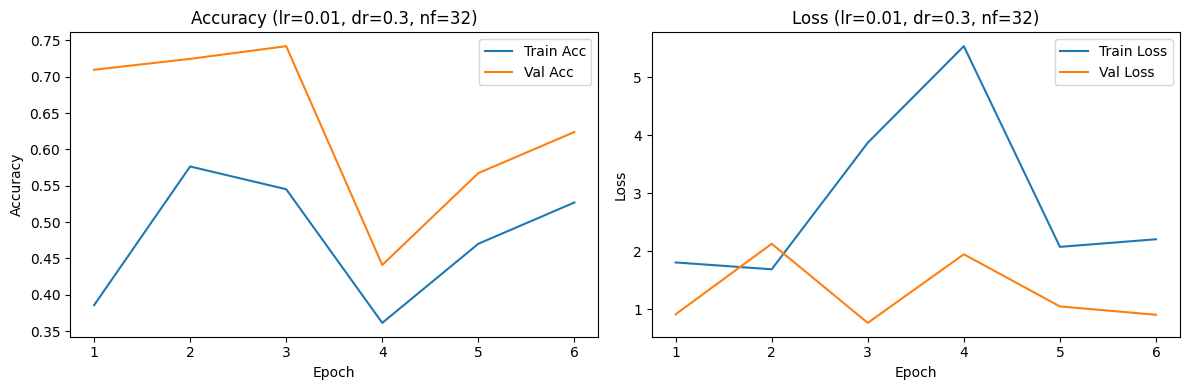


Training model: LR=0.01, Dropout=0.3, Filters=64
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.67893, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.3_nf64.keras
151/151 - 9s - 60ms/step - accuracy: 0.3302 - loss: 1.9677 - val_accuracy: 0.7063 - val_loss: 1.6789
Epoch 2/10

Epoch 2: val_loss improved from 1.67893 to 1.12017, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.3_nf64.keras
151/151 - 10s - 65ms/step - accuracy: 0.6093 - loss: 1.3954 - val_accuracy: 0.7404 - val_loss: 1.1202
Epoch 3/10

Epoch 3: val_loss improved from 1.12017 to 0.57389, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.3_nf64.keras
151/151 - 8s - 55ms/step - accuracy: 0.6331 - loss: 1.5526 - val_accuracy: 0.7421 - val_loss: 0.5739
Epoch 4/10

Epoch 4: val_loss did not improve from 0.57389
151/151 - 8s - 56ms/step - accuracy: 0.6329 - loss: 2.2723 - val_accuracy: 0.7363 - val_loss: 0.6238
Epoch 5/10

Epoch 5: val_loss did not improve from 0.57389
151/151 - 9

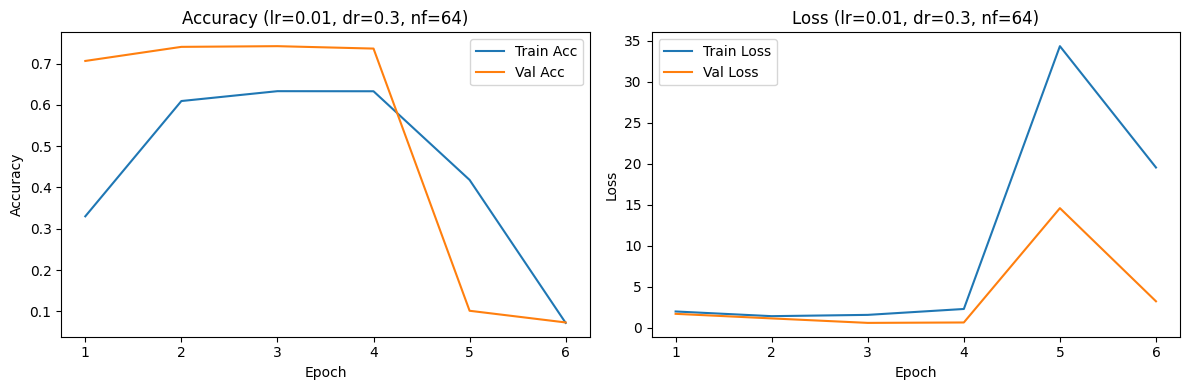


Training model: LR=0.01, Dropout=0.5, Filters=32
Epoch 1/10

Epoch 1: val_loss improved from inf to 1.12623, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.5_nf32.keras
151/151 - 7s - 50ms/step - accuracy: 0.3627 - loss: 1.8549 - val_accuracy: 0.6364 - val_loss: 1.1262
Epoch 2/10

Epoch 2: val_loss improved from 1.12623 to 0.65069, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.5_nf32.keras
151/151 - 7s - 44ms/step - accuracy: 0.6134 - loss: 1.2433 - val_accuracy: 0.7429 - val_loss: 0.6507
Epoch 3/10

Epoch 3: val_loss did not improve from 0.65069
151/151 - 7s - 44ms/step - accuracy: 0.7198 - loss: 1.2859 - val_accuracy: 0.7737 - val_loss: 0.7014
Epoch 4/10

Epoch 4: val_loss did not improve from 0.65069
151/151 - 7s - 44ms/step - accuracy: 0.4081 - loss: 1.9785 - val_accuracy: 0.6414 - val_loss: 1.1042
Epoch 5/10

Epoch 5: val_loss did not improve from 0.65069
151/151 - 7s - 46ms/step - accuracy: 0.4859 - loss: 2.2465 - val_accuracy: 0.3727 - val_loss:

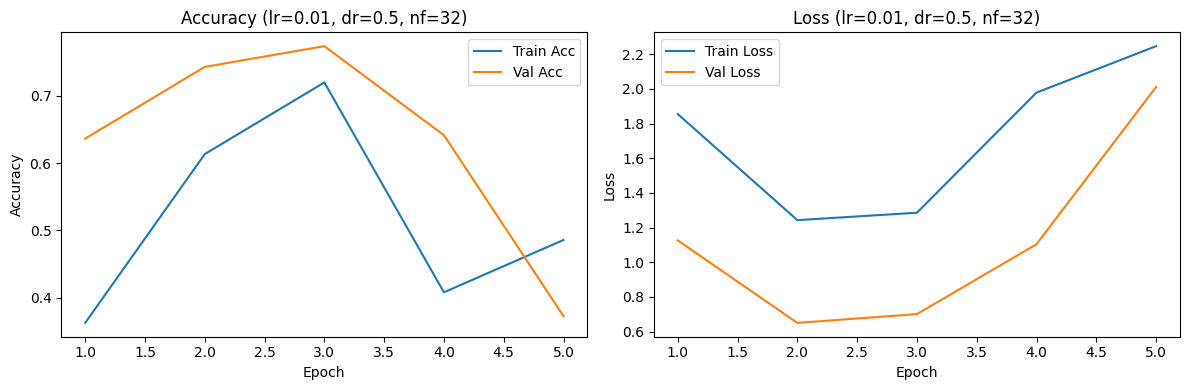


Training model: LR=0.01, Dropout=0.5, Filters=64
Epoch 1/10

Epoch 1: val_loss improved from inf to 0.73261, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.5_nf64.keras
151/151 - 9s - 59ms/step - accuracy: 0.3521 - loss: 1.8610 - val_accuracy: 0.7163 - val_loss: 0.7326
Epoch 2/10

Epoch 2: val_loss improved from 0.73261 to 0.43515, saving model to LeNet-5/hyperparameter_results/best_lr0.01_dr0.5_nf64.keras
151/151 - 9s - 57ms/step - accuracy: 0.6674 - loss: 0.9889 - val_accuracy: 0.8444 - val_loss: 0.4352
Epoch 3/10

Epoch 3: val_loss did not improve from 0.43515
151/151 - 10s - 69ms/step - accuracy: 0.7200 - loss: 1.0587 - val_accuracy: 0.6922 - val_loss: 1.7316
Epoch 4/10

Epoch 4: val_loss did not improve from 0.43515
151/151 - 9s - 57ms/step - accuracy: 0.5973 - loss: 2.0113 - val_accuracy: 0.7870 - val_loss: 0.4975
Epoch 5/10

Epoch 5: val_loss did not improve from 0.43515
151/151 - 9s - 59ms/step - accuracy: 0.6195 - loss: 2.2280 - val_accuracy: 0.6988 - val_loss

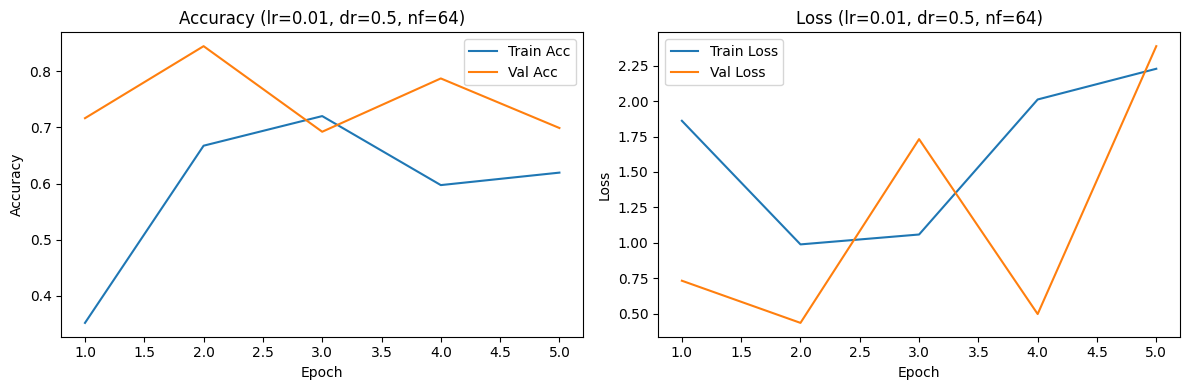

In [27]:
# ─── 4. Hyperparameter tuning ─────────────────────────────────────────────

learning_rates = [0.001, 0.005, 0.01]
dropout_rates = [0.3, 0.5]
num_filters_list = [32, 64]

results = []  # To store best result of each configuration

for lr in learning_rates:
    for dr in dropout_rates:
        for nf in num_filters_list:
            print(f"\nTraining model: LR={lr}, Dropout={dr}, Filters={nf}")
            model, history = train_model(train_data, val_data, lr, dr, nf, epochs=10)

            # Get best validation accuracy and corresponding loss
            best_epoch = np.argmax(history.history['val_accuracy'])
            best_val_acc = history.history['val_accuracy'][best_epoch]
            best_val_loss = history.history['val_loss'][best_epoch]

            results.append({
                'Learning Rate': lr,
                'Dropout Rate': dr,
                'Num Filters': nf,
                'Best Epoch': best_epoch + 1,
                'Best Val Accuracy': round(best_val_acc, 4),
                'Best Val Loss': round(best_val_loss, 4)
            })

            plot_training_results(history, lr, dr, nf)
            

In [29]:
#───────── 5. Display and Save Results from Hyperparameter Tuning ─────────────────────────────────────────────

# Convert list of result dicts to a DataFrame
results_df = pd.DataFrame(results)

# Print a clean table of all results
print("\n=== Hyperparameter Tuning Summary ===")
print(results_df.to_string(index=False))

# Identify best configurations
best_acc_result = results_df.loc[results_df['Best Val Accuracy'].idxmax()]
best_loss_result = results_df.loc[results_df['Best Val Loss'].idxmin()]

# Print best results
print("\n=== Best by Validation Accuracy ===")
print(best_acc_result)

print("\n=== Best by Validation Loss ===")
print(best_loss_result)

# Save the results to a CSV file in the LeNet-5 folder
log_folder = "LeNet-5"
os.makedirs(log_folder, exist_ok=True)
csv_path = os.path.join(log_folder, "lenet5_hyperparameter_summary.csv")
results_df.to_csv(csv_path, index=False)
print(f"\nSummary saved to: {csv_path}")



=== Hyperparameter Tuning Summary ===
 Learning Rate  Dropout Rate  Num Filters  Best Epoch  Best Val Accuracy  Best Val Loss
         0.001           0.3           32           9             0.9468         0.1625
         0.001           0.3           64           9             0.9451         0.1669
         0.001           0.5           32          10             0.9093         0.3773
         0.001           0.5           64          10             0.8844         0.3536
         0.005           0.3           32           7             0.9834         0.0479
         0.005           0.3           64           5             0.9892         0.0440
         0.005           0.5           32           2             0.8220         0.4089
         0.005           0.5           64           5             0.9517         0.0993
         0.010           0.3           32           3             0.7421         0.7681
         0.010           0.3           64           3             0.7421         

In [30]:
#───────── 6. Save Best Overall Hyperparameters to File ─────────────────────────────────────────────

best_summary_path = os.path.join("LeNet-5", "best_hyperparameters.txt")

with open(best_summary_path, "w") as f:
    f.write("=== Best Configuration by Validation Accuracy ===\n")
    f.write(best_acc_result.to_string())

print(f"\nBest configurations saved to: {best_summary_path}")


Best configurations saved to: LeNet-5/best_hyperparameters.txt


Testing the best model on the Test Data

In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [39]:
# Load the trained model

model = load_model("LeNet-5/hyperparameter_results/best_lr0.005_dr0.3_nf64.keras")


In [42]:
# Adjust these values to match your training setup

img_height, img_width = 100, 100
batch_size = 32

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

test_data = test_datagen.flow_from_directory(
    test_path ,  # Update this path
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# --- Get class labels ---
class_names = list(test_data.class_indices.keys())
steps = int(np.ceil(test_data.n / test_data.batch_size))
print("Expected number of steps:", steps)


Found 663 images belonging to 14 classes.
Expected number of steps: 21


In [43]:

# Predict labels on test data

# --- Get true labels ---
y_true = []
for i in range(steps):
    images, labels = next(test_data)
    y_true.extend(np.argmax(labels, axis=1))  # use np.argmax if labels are one-hot
    print(f"Processed batch {i+1}/{steps} for y_true extraction")
y_true = np.array(y_true)

# Reset the generator before prediction
test_data.reset()

# --- Predict on test data with progress ---
start_time = time.time()
y_pred_probs = model.predict(test_data, steps=steps, verbose=1)
end_time = time.time()
print(f"Prediction completed in {end_time - start_time:.2f} seconds")

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

print("Finished predictions.")


Processed batch 1/21 for y_true extraction
Processed batch 2/21 for y_true extraction
Processed batch 3/21 for y_true extraction
Processed batch 4/21 for y_true extraction
Processed batch 5/21 for y_true extraction
Processed batch 6/21 for y_true extraction
Processed batch 7/21 for y_true extraction
Processed batch 8/21 for y_true extraction
Processed batch 9/21 for y_true extraction
Processed batch 10/21 for y_true extraction
Processed batch 11/21 for y_true extraction
Processed batch 12/21 for y_true extraction
Processed batch 13/21 for y_true extraction
Processed batch 14/21 for y_true extraction
Processed batch 15/21 for y_true extraction
Processed batch 16/21 for y_true extraction
Processed batch 17/21 for y_true extraction
Processed batch 18/21 for y_true extraction
Processed batch 19/21 for y_true extraction
Processed batch 20/21 for y_true extraction
Processed batch 21/21 for y_true extraction


/Users/krishnaajaishi/tf_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Prediction completed in 1.17 seconds
Finished predictions.


In [44]:
# Evaluate accuracy and loss
test_loss, test_acc = model.evaluate(test_data, verbose=0)

# --- Metrics ---
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_text = classification_report(y_true, y_pred, target_names=class_names)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
test_loss, test_acc = model.evaluate(test_data, verbose=0)

# --- Save results ---
os.makedirs("LeNet-5", exist_ok=True)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9894
Test Loss: 0.0462


In [45]:
# Save evaluation summary to text file

with open("LeNet-5/test_results_summary.txt", "w") as f:
    f.write(f" Test Accuracy: {test_acc:.4f}\n")
    f.write(f" Test Loss: {test_loss:.4f}\n\n")
    f.write(" Classification Report:\n")
    f.write(report_text)


In [46]:
# Save classification report as CSV

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("LeNet-5/classification_report.csv", index=True)


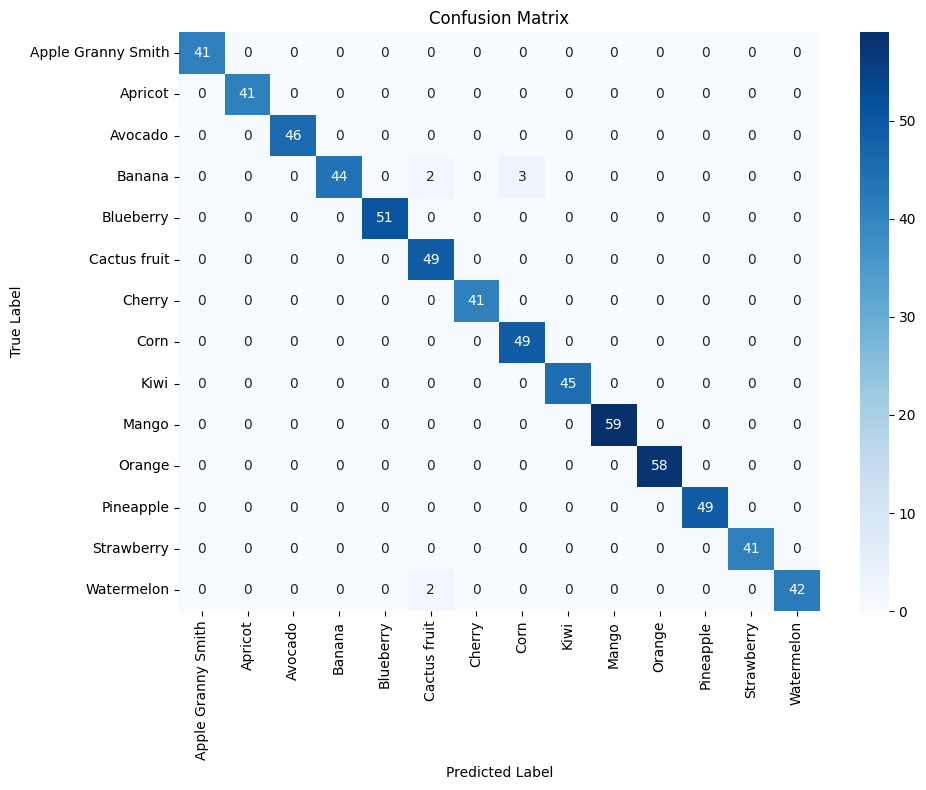

In [47]:
# Generate and save confusion matrix as PNG

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("LeNet-5/confusion_matrix.png")
plt.show()



 Misclassified Samples (showing up to 50):

Total Misclassified Samples: 7 



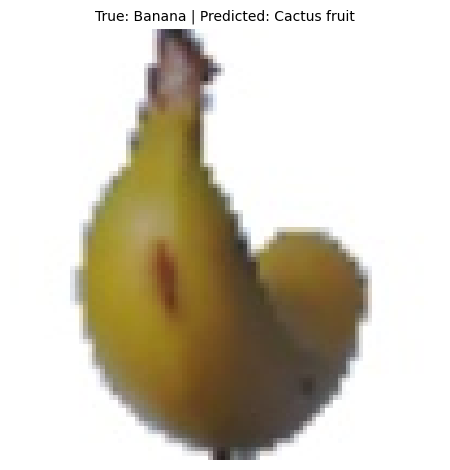

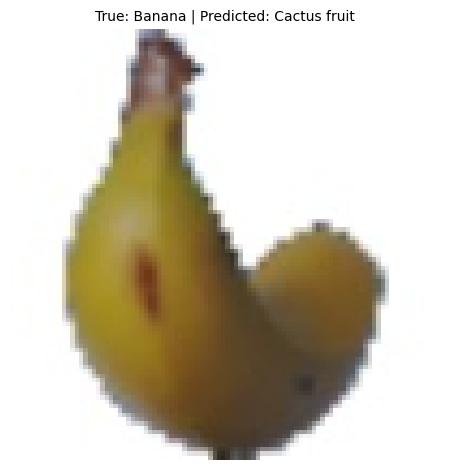

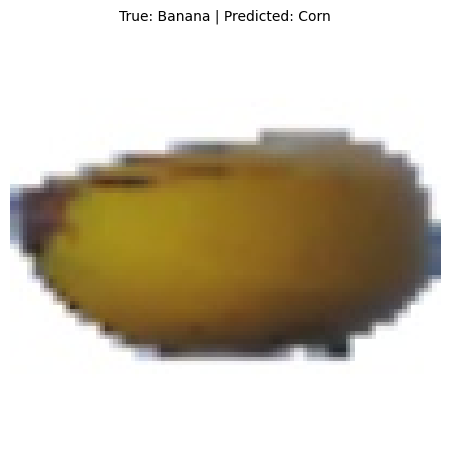

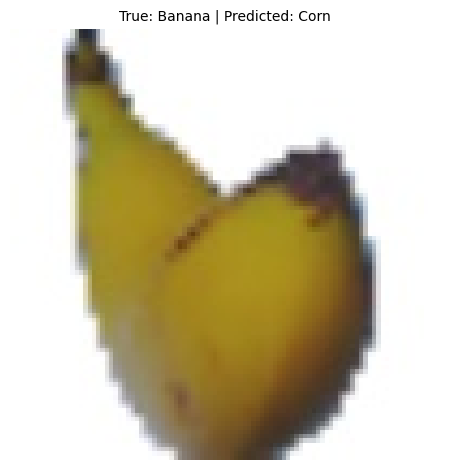

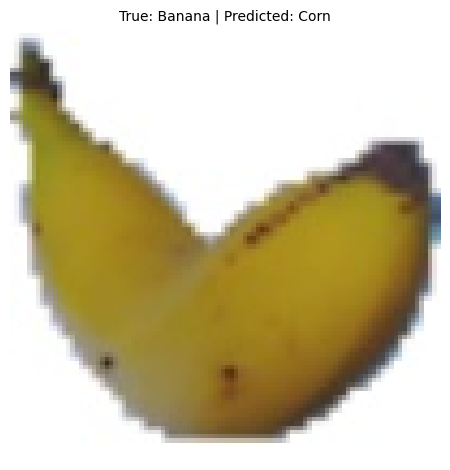

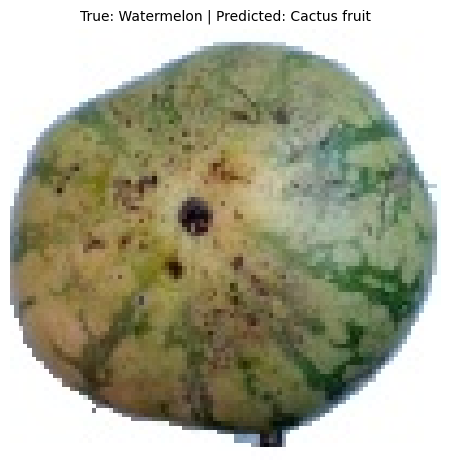

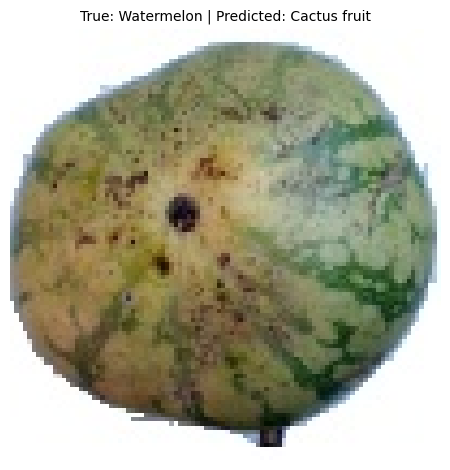

In [53]:
# --- Show misclassified images inline ---
print("\n Misclassified Samples (showing up to 50):")
misclassified_indices = np.where(y_pred != y_true)[0]
misclassified_filenames = np.array(test_data.filenames)[misclassified_indices]

# Print total count of misclassified fruits
print(f"\nTotal Misclassified Samples: {len(misclassified_indices)} \n")

for i in range(min(50, len(misclassified_indices))):
    img_path = os.path.join(test_data.directory, misclassified_filenames[i])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    true_label = class_names[y_true[misclassified_indices[i]]]
    pred_label = class_names[y_pred[misclassified_indices[i]]]
    
    plt.imshow(img)
    plt.title(f"True: {true_label} | Predicted: {pred_label}", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    


In [54]:

print(" Results saved to:")
print("- LeNet-5/test_results_summary.txt")
print("- LeNet-5/classification_report.csv")
print("- LeNet-5/confusion_matrix.png")


 Results saved to:
- LeNet-5/test_results_summary.txt
- LeNet-5/classification_report.csv
- LeNet-5/confusion_matrix.png
